# Data Prep for contest Synapse CODA TB DREAM Challenge

Prepares metadata for training
* merging the TB status and other clinical and demographic data
* creating cross-validation folds
* processing both the solicited and the longitudinal cough audio samples
* plot waveforms and spectrographs

## File locations

In [1]:
from pathlib import Path
import pandas as pd
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold
import torchaudio

In [2]:
data_dir = Path('/media/SSD/CODA-TB/data')

In [3]:
def find_path(filename,directory_path=data_dir):
    l = list(directory_path.glob("**/" + filename))
    if len(l) == 0:
        return None
    elif len(l) == 1:
        return l[0]
    else:
        return l

In [4]:
find_path('CODA_TB_Solicited_Meta_Info.csv')

PosixPath('/media/SSD/CODA-TB/data/metadata/CODA_TB_Solicited_Meta_Info.csv')

In [5]:
solicited_df = pd.read_csv(find_path('CODA_TB_Solicited_Meta_Info.csv'))
clinical_df = pd.read_csv(find_path('CODA_TB_Clinical_Meta_Info.csv'))
longitudinal_df = pd.read_csv(find_path('CODA_TB_Longitudnal_Meta_Info.csv'))

In [6]:
clinical_df

,participant,sex,age,height,weight,reported_cough_dur,tb_prior,tb_prior_Pul,tb_prior_Extrapul,tb_prior_Unknown,hemoptysis,heart_rate,temperature,weight_loss,smoke_lweek,fever,night_sweats,tb_status
0,CODA_TB_0001,Male,27,173.3,63.0,30,No,No,No,No,No,99,37.2,Yes,No,Yes,Yes,0
1,CODA_TB_0002,Female,48,163.0,49.9,16,Yes,Yes,No,No,No,80,36.6,Yes,No,No,Yes,1
2,CODA_TB_0003,Male,51,165.0,58.0,14,Yes,No,Yes,No,No,100,37.0,Yes,No,No,No,0
3,CODA_TB_0004,Male,32,166.0,56.0,90,No,No,No,No,No,90,37.0,Yes,No,No,Yes,0
4,CODA_TB_0005,Male,28,170.5,53.0,14,No,No,No,No,No,94,36.0,No,No,No,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1100,CODA_TB_1103,Male,51,163.0,46.0,90,No,No,No,No,No,96,37.2,Yes,No,Yes,Yes,0
1101,CODA_TB_1104,Female,54,156.0,70.5,21,Yes,Yes,No,No,No,84,36.1,Yes,No,No,No,0
1102,CODA_TB_1105,Female,34,168.0,47.3,60,Yes,Yes,No,No,Yes,96,36.3,Yes,Yes,No,No,0
1103,CODA_TB_1106,Female,63,154.0,48.0,90,No,No,No,No,No,100,36.9,No,No,No,No,1


In [7]:
solicited_df

,participant,filename,sound_prediction_score
0,CODA_TB_0001,1645088710003-recording-1.wav,0.990254
1,CODA_TB_0001,1645088760390-recording-1.wav,0.990272
2,CODA_TB_0001,1645088760830-recording-1.wav,0.990112
3,CODA_TB_0001,1645088710843-recording-1.wav,0.990152
4,CODA_TB_0001,1645088759950-recording-1.wav,0.990039
...,...,...,...
9767,CODA_TB_1107,1658214018804-recording-1.wav,0.941761
9768,CODA_TB_1107,1658213992939-recording-1.wav,0.904569
9769,CODA_TB_1107,1658213992139-recording-1.wav,0.934713
9770,CODA_TB_1107,1658213940569-recording-1.wav,0.912813


In [8]:
solicited_df.describe()

,sound_prediction_score
count,9772.000000
mean,0.965072
std,0.033784
min,0.850029
25%,0.940641
50%,0.983455
75%,0.990249
max,1.000000


In [9]:
clinical_df.describe()

,age,height,weight,reported_cough_dur,heart_rate,temperature,tb_status
count,1105.000000,1104.000000,1105.000000,1105.000000,1105.000000,1105.000000,1105.000000
mean,40.850679,161.749819,57.690407,47.031674,86.170136,36.721719,0.268778
std,15.294641,8.796219,13.683393,54.996475,16.741211,0.541852,0.443525
min,18.000000,138.000000,30.000000,4.000000,20.000000,35.100000,0.000000
25%,28.000000,155.150000,49.000000,16.000000,74.000000,36.400000,0.000000
50%,39.000000,162.000000,55.000000,30.000000,85.000000,36.700000,0.000000
75%,53.000000,168.000000,64.800000,60.000000,96.000000,37.000000,1.000000
max,85.000000,198.000000,158.800000,365.000000,153.000000,40.200000,1.000000


In [10]:
longitudinal_df

,participant,filename,sound_prediction_score
0,CODA_TB_0002,1643801612706-recording-1.wav,0.856933
1,CODA_TB_0002,1643799201914-recording-1.wav,0.984978
2,CODA_TB_0002,1643798164476-recording-1.wav,0.981475
3,CODA_TB_0002,1643798084611-recording-1.wav,0.976238
4,CODA_TB_0002,1643801346641-recording-1.wav,0.980508
...,...,...,...
714917,CODA_TB_1105,1645769560741-recording-1.wav,0.929447
714918,CODA_TB_1106,1641287918092-recording-1.wav,0.918152
714919,CODA_TB_1106,1641289828296-recording-1.wav,0.975834
714920,CODA_TB_1106,1641293091855-recording-1.wav,0.948408


In [11]:
longitudinal_df.describe()

,sound_prediction_score
count,714922.000000
mean,0.957793
std,0.038577
min,0.850001
25%,0.936385
50%,0.967644
75%,0.990129
max,1.000000


## Add metadata - sample length

In [12]:
def get_sample_length(fn,base_path):
    p = base_path/fn
    x, sr = torchaudio.load(str(p))
    return x.shape[1]
    

In [13]:
solicited_path = data_dir/'solicited'

In [14]:
get_sample_length('1645088710003-recording-1.wav',solicited_path)

22050

In [15]:
#add samples
solicited_df['samples'] = solicited_df.apply(lambda row: get_sample_length(row['filename'],solicited_path ), axis=1)

## Create Training+Validation data frame

Using just Solicited initially

In [16]:
#add tb_status
challenge1_df = pd.merge(solicited_df, clinical_df[['participant', 'tb_status']], on = 'participant', how = 'inner')

In [17]:
challenge1_df

,participant,filename,sound_prediction_score,samples,tb_status
0,CODA_TB_0001,1645088710003-recording-1.wav,0.990254,22050,0
1,CODA_TB_0001,1645088760390-recording-1.wav,0.990272,22050,0
2,CODA_TB_0001,1645088760830-recording-1.wav,0.990112,22050,0
3,CODA_TB_0001,1645088710843-recording-1.wav,0.990152,22050,0
4,CODA_TB_0001,1645088759950-recording-1.wav,0.990039,22050,0
...,...,...,...,...,...
9767,CODA_TB_1107,1658214018804-recording-1.wav,0.941761,22050,0
9768,CODA_TB_1107,1658213992939-recording-1.wav,0.904569,22050,0
9769,CODA_TB_1107,1658213992139-recording-1.wav,0.934713,22050,0
9770,CODA_TB_1107,1658213940569-recording-1.wav,0.912813,22050,0


### Look at missing participants between data sets

In [18]:
solicited_df['participant'].drop_duplicates().isin(clinical_df['participant']).value_counts()

True    1082
Name: participant, dtype: int64

In [19]:
clinical_df['participant'].isin(solicited_df['participant'].drop_duplicates()).value_counts()

True     1082
False      23
Name: participant, dtype: int64

In [20]:
longitudinal_df['participant'].drop_duplicates().isin(clinical_df['participant']).value_counts()

True    565
Name: participant, dtype: int64

In [21]:
clinical_df['participant'].isin(longitudinal_df['participant'].drop_duplicates()).value_counts()

True     565
False    540
Name: participant, dtype: int64

In [22]:
longitudinal_df['participant'].drop_duplicates().isin(solicited_df['participant'].drop_duplicates()).value_counts()

True     542
False     23
Name: participant, dtype: int64

In [23]:
solicited_df['participant'].drop_duplicates().isin(longitudinal_df['participant'].drop_duplicates()).value_counts()

True     542
False    540
Name: participant, dtype: int64

In [24]:
challenge1_df

,participant,filename,sound_prediction_score,samples,tb_status
0,CODA_TB_0001,1645088710003-recording-1.wav,0.990254,22050,0
1,CODA_TB_0001,1645088760390-recording-1.wav,0.990272,22050,0
2,CODA_TB_0001,1645088760830-recording-1.wav,0.990112,22050,0
3,CODA_TB_0001,1645088710843-recording-1.wav,0.990152,22050,0
4,CODA_TB_0001,1645088759950-recording-1.wav,0.990039,22050,0
...,...,...,...,...,...
9767,CODA_TB_1107,1658214018804-recording-1.wav,0.941761,22050,0
9768,CODA_TB_1107,1658213992939-recording-1.wav,0.904569,22050,0
9769,CODA_TB_1107,1658213992139-recording-1.wav,0.934713,22050,0
9770,CODA_TB_1107,1658213940569-recording-1.wav,0.912813,22050,0


In [25]:
# reset index so that .loc and .iloc are same for index
challenge1_df.reset_index(drop=True,inplace=True)

In [26]:
#add orig_id
challenge1_df['orig_id'] = challenge1_df.index

## Training and validation set splitting

In [27]:
n_folds = 5
seed = 42

In [28]:
#We will use n fold cross validation, which will create 5 training sets of 80% of the data
# and 5 validation sets of 20% of the data.
# We use the participant to stratify the folds so that participants are not split between training and val sets

skf = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state=seed)
for fold, (train_idx, val_idx) in enumerate(skf.split(challenge1_df, challenge1_df['tb_status'], groups = challenge1_df["participant"])):
    challenge1_df.loc[val_idx, 'fold'] = fold


In [29]:
challenge1_df

,participant,filename,sound_prediction_score,samples,tb_status,orig_id,fold
0,CODA_TB_0001,1645088710003-recording-1.wav,0.990254,22050,0,0,1.0
1,CODA_TB_0001,1645088760390-recording-1.wav,0.990272,22050,0,1,1.0
2,CODA_TB_0001,1645088760830-recording-1.wav,0.990112,22050,0,2,1.0
3,CODA_TB_0001,1645088710843-recording-1.wav,0.990152,22050,0,3,1.0
4,CODA_TB_0001,1645088759950-recording-1.wav,0.990039,22050,0,4,1.0
...,...,...,...,...,...,...,...
9767,CODA_TB_1107,1658214018804-recording-1.wav,0.941761,22050,0,9767,1.0
9768,CODA_TB_1107,1658213992939-recording-1.wav,0.904569,22050,0,9768,1.0
9769,CODA_TB_1107,1658213992139-recording-1.wav,0.934713,22050,0,9769,1.0
9770,CODA_TB_1107,1658213940569-recording-1.wav,0.912813,22050,0,9770,1.0


In [30]:
display(challenge1_df.groupby(['fold','tb_status'])['filename'].count())

fold  tb_status
0.0   0            1352
      1             599
1.0   0            1334
      1             626
2.0   0            1408
      1             577
3.0   0            1334
      1             592
4.0   0            1414
      1             536
Name: filename, dtype: int64

## Output the files for training

In [ ]:
challenge1_df.to_csv(data_dir/'metadata'/"challenge1_metadata.csv")

## Process the longitudinal data and use the cross validation subject splits

### Add metadata - sample length

In [ ]:
def get_sample_length(fn,base_path):
    p = base_path/fn
    x, sr = torchaudio.load(str(p))
    return x.shape[1]
    

In [ ]:
longitudinal_path = data_dir/'longitudinal'

In [ ]:
get_sample_length('1645088710003-recording-1.wav',solicited_path)

In [ ]:
#add samples
longitudinal_df['samples'] = longitudinal_df.apply(lambda row: get_sample_length(row['filename'],
                                                                                 longitudinal_path ), axis=1)

In [ ]:
#add tb_status
challenge1_long_df = pd.merge(longitudinal_df, clinical_df[['participant', 'tb_status']],
                              on = 'participant', how = 'inner')

In [ ]:
# reset index so that .loc and .iloc are same for index
challenge1_long_df.reset_index(drop=True,inplace=True)

In [ ]:
#add orig_id
challenge1_long_df['orig_id'] = challenge1_long_df.index

In [ ]:
# get table of participants and folds
participant_folds_df = challenge1_df.drop_duplicates(subset=['participant'])

In [ ]:
#add folds
challenge1_long_df = pd.merge(challenge1_long_df, participant_folds_df[['participant','fold']],
                              on='participant',how='left')

In [ ]:
challenge1_long_df.drop_duplicates(subset=['fold'])

In [ ]:
challenge1_long_df.fillna(5,inplace=True)

In [ ]:
challenge1_long_df.drop_duplicates(subset=['fold'])

In [ ]:
challenge1_long_df.groupby('fold').size()

In [ ]:
challenge1_df.columns

In [ ]:
challenge1_long_df.columns

In [ ]:
#output the data
challenge1_long_df.to_csv(data_dir/'metadata'/"challenge1_long_metadata.csv")

## Apply cross-validation splits to the Challenge 2 data (clinical input data)

In [ ]:
challenge2_df = clinical_df.copy()

In [ ]:
# reset index so that .loc and .iloc are same for index
challenge2_df.reset_index(drop=True,inplace=True)

In [ ]:
#add orig_id
challenge2_df['orig_id'] = challenge2_df.index

In [ ]:
#add folds
challenge2_df = pd.merge(challenge2_df, participant_folds_df[['participant','fold']],
                              on='participant',how='left')

In [ ]:
challenge2_df

In [ ]:
challenge2_df.fillna(5,inplace=True)

In [ ]:
challenge2_df.drop_duplicates(subset=['fold'])

In [ ]:
challenge2_df.groupby('fold').size()

In [ ]:
#output the data
challenge2_df.to_csv(data_dir/'metadata'/"challenge2_metadata.csv")

## Listen and view some recordings

In [134]:
from IPython.display import Audio, display
import librosa
import numpy as np
import matplotlib.pyplot as plt
import torch


def play_audio(waveform, sample_rate):
    """Play an audio sample in a notebook

    Parameters
    ----------
    waveform: array
        An array of 1 or two channels of samples.
    sample_rate: int
        The sample rate in samples per second.
        
    """    
    
    
    if type(waveform) != np.ndarray:
        waveform = waveform.numpy()
        
    if len(waveform.shape) == 1:
        waveform = np.expand_dims(waveform, axis=0)
    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError(
            "Waveform with more than 2 channels are not supported.")


def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
        print("Shape:", tuple(waveform.shape))
        print("Dtype:", waveform.dtype)
        print(f" - Max:     {waveform.max().item():6.3f}")
        print(f" - Min:     {waveform.min().item():6.3f}")
        print(f" - Mean:    {waveform.mean().item():6.3f}")
        print(f" - Std Dev: {waveform.std().item():6.3f}")
        print()
        print(waveform)
        print()


def plot_waveform(waveform,
                  sample_rate,
                  title="Waveform",
                  xlim=None,
                  ylim=None):
    if type(waveform) != np.ndarray:
        waveform = waveform.numpy()

    num_frames = waveform.shape[0]
    time_axis = torch.arange(0, num_frames) / sample_rate
    figure, axes = plt.subplots(1, figsize=(12, 6))
    
    
    axes.plot(time_axis, waveform, linewidth=1, color="#A300F9")
    axes.set_xlabel('time (sec)')
    axes.set_ylabel('amplitude')

    if xlim:
        axes.set_xlim(xlim)
    if ylim:
        axes.set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)




In [135]:
def plot_spectrogram(waveform, 
                     sr, 
                     lf=50, 
                     hf=15000,
                     title=None,
                     ylabel='frequency (Hz)',
                     aspect='auto',
                     xmax=None):
    
 
    x = np.abs(librosa.stft(waveform,n_fft = 1024,hop_length=64,window ='hanning'))
    x = librosa.amplitude_to_db(x).astype(np.float32)
    x = (x-np.min(x))/(np.max(x)-np.min(x))
    
    f_factor = x.shape[0]/sr*2
    lf_index = int(f_factor*lf)
    hf_index = int(f_factor*hf)
    x = np.flip(x[lf_index:hf_index,:],0).copy() 
    
    fig = plt.figure(figsize=(12, 6))
    axs = fig.add_subplot(111)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('time (sec)')
    im = axs.imshow(x, aspect=aspect,extent=[0,waveform.shape[0]/sr,lf,hf])
    #im = axs.imshow(torchaudio.functional.amplitude_to_DB(spec), origin='lower', aspect=aspect)
    plt.yticks(list(plt.yticks()[0])[1:-1] + [lf,hf])
    
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [136]:
def show_waveform(waveform,sr):
    plot_waveform(waveform,sr)
    plot_spectrogram(waveform,sr) 
    play_audio(waveform, sr)

In [137]:
def read_waveform(row, input_path='/media/SSD/CODA-TB/data/solicited'):
    waveform, sr = librosa.load(input_path + '/' + row['filename'],sr=None)
    return waveform, sr


In [138]:
challenge1_df = pd.read_csv(data_dir/'metadata'/"challenge1_metadata.csv",index_col=[0])

In [139]:
tb_yes = challenge1_df[challenge1_df['tb_status']==1]
tb_no = challenge1_df[challenge1_df['tb_status']==0]


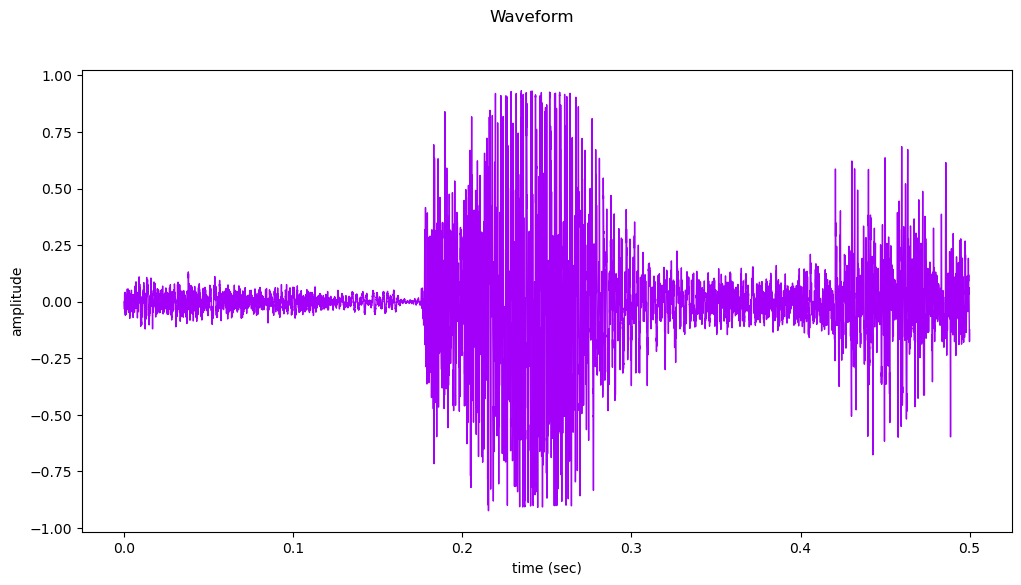

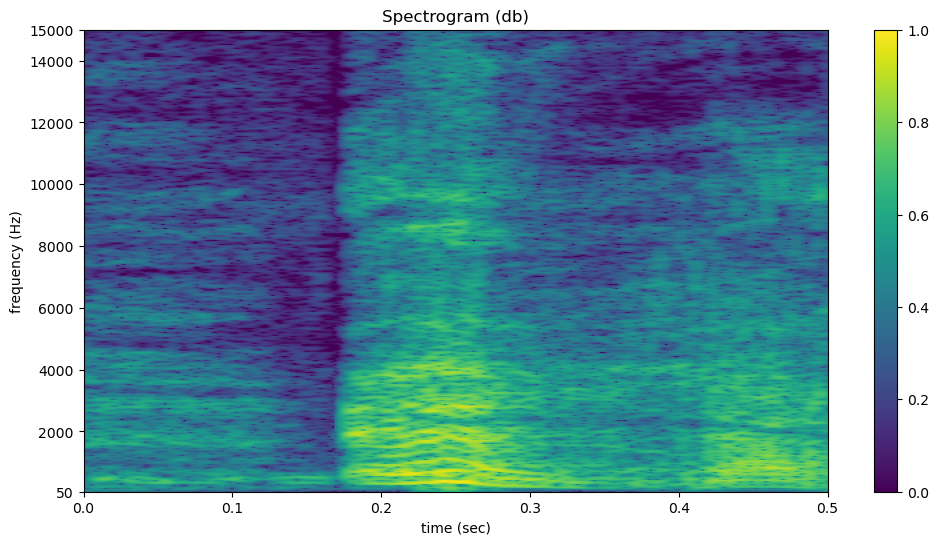

In [140]:
show_waveform(*read_waveform(tb_yes.iloc[20]))

### Review Class Balance for Solicited data

In [141]:
df_counts = pd.DataFrame(challenge1_df.groupby(['tb_status']).size().reset_index()).rename(columns={0:"counts"})

In [142]:
df_counts

,tb_status,counts
0,0,6842
1,1,2930
